# The Bachelorette Predictor
### Kwame V. Taylor

The goal of this project is to create a machine learning model that accurately predicts how many weeks a contestant will last on the ABC reality show The Bachelorette, based on data from Seasons 1-2 and 4-12.

**Warning: This project contains *many* spoilers for past seasons.** Proceed at your own risk.

<img src="https://miro.medium.com/max/1280/1*S6OS8YFJWx0LT9wXNi0LkQ.png">

## Set up Environment

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import matplotlib as mpl

from cycler import cycler
import seaborn as sns

# default viz size settings
plt.rc('figure', figsize=(12, 8))
plt.rc('font', size=15)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'
mpl.rcParams['axes.prop_cycle'] = cycler(color=['deepskyblue', 'firebrick', 'darkseagreen', 'violet'])

import warnings
warnings.filterwarnings("ignore")

In [2]:
from wrangle import acquire_data, join_dfs, drop_extra_cols
from preprocessing import handle_dates_and_elims, train_validate_test, parse_hometowns
from explore import make_heatmap, firstdate_swarmplot, swarmplot_by_season, pearsons_test
from model import model_1, model_1_test, evaluate_baseline

## Acquire & Prepare (Wrangle) the Data

Import raw datasets.

In [3]:
df, join = acquire_data()

In [4]:
df.head(3)

,Name,Age,Occupation,Hometown,ElimWeek,Season
0,Ryan Sutter,29,Firefighter,"Vail, Colorado",NaN,1
1,Charlie Maher,28,Financial Analyst,"Hermosa Beach, California",6.0,1
2,Russ,30,Writer,"San Rafael, California",5.0,1


In [5]:
join.sort_values(by='SEASON').head(3)

,SEASON,CONTESTANT,ELIMINATION-1,ELIMINATION-2,ELIMINATION-3,ELIMINATION-4,ELIMINATION-5,ELIMINATION-6,ELIMINATION-7,ELIMINATION-8,...,DATES-1,DATES-2,DATES-3,DATES-4,DATES-5,DATES-6,DATES-7,DATES-8,DATES-9,DATES-10
281,1,01_WAYNE_X,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,1,01_RYAN_S,NaN,NaN,NaN,NaN,NaN,W,NaN,NaN,...,NaN,D14,D1,D1,D1,D1,NaN,NaN,NaN,NaN
258,1,01_CHARLIE_M,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,...,NaN,D14,D1,D1,D1,D1,NaN,NaN,NaN,NaN


How to read the ```join``` DataFrame:

Feature         | Description
----------------|------------
`ELIMINATION-1` | Who was eliminated in week 1
`ELIMINATION-2` | Who was eliminated in week 2
`ELIMINATION-3` | Who was eliminated in week 3
`ELIMINATION-4` | Who was eliminated in week 4
`ELIMINATION-5` | Who was eliminated in week 5
`ELIMINATION-6` | Who was eliminated in week 6
`ELIMINATION-7` | Who was eliminated in week 7
`ELIMINATION-8` | Who was eliminated in week 8
`ELIMINATION-9` | Who was eliminated in week 9
`ELIMINATION-10`| Who was eliminated in week 10
`DATES-1`       | Who was on which date in week 1
`DATES-2`       | Who was on which date in week 2
`DATES-3`       | Who was on which date in week 3
`DATES-4`       | Who was on which date in week 4
`DATES-5`       | Who was on which date in week 5
`DATES-6`       | Who was on which date in week 6
`DATES-7`       | Who was on which date in week 7
`DATES-8`       | Who was on which date in week 8
`DATES-9`       | Who was on which date in week 9
`DATES-10`      | Who was on which date in week 10

- Eliminates connote either an elimination (starts with "E") or a rose (starts with "R").
- Eliminations supercede roses.
- "E" connotes a standard elimination, typically at a rose ceremony. "EQ" means the contestant quits. "EF" means the contestant was fired by production. "ED" connotes a date elimination. "EU" connotes an unscheduled elimination, one that takes place at a time outside of a date or rose ceremony.
- "R" means the contestant received a rose. "R1" means the contestant got a first impression rose.
- "D1" means a one-on-one date, "D2" means a 2-on-1, "D3" means a 3-on-1 group date, and so on.
- Weeks of the show are deliminated by rose ceremonies, and may not line up exactly with episodes.

Now I'll join the two dataframes.

In [6]:
df = join_dfs(df, join)

In [7]:
df.head(3)

,Name,Age,Occupation,Hometown,ElimWeek,Season,ELIMINATION-1,ELIMINATION-2,ELIMINATION-3,ELIMINATION-4,...,DATES-1,DATES-2,DATES-3,DATES-4,DATES-5,DATES-6,DATES-7,DATES-8,DATES-9,DATES-10
CONTESTANT,,,,,,,,,,,,,,,,,,,,,
1_RYAN_S,Ryan Sutter,29,Firefighter,"Vail, Colorado",NaN,1,NaN,NaN,NaN,NaN,...,NaN,D14,D1,D1,D1,D1,NaN,NaN,NaN,NaN
1_CHARLIE_M,Charlie Maher,28,Financial Analyst,"Hermosa Beach, California",6.0,1,NaN,NaN,NaN,NaN,...,NaN,D14,D1,D1,D1,D1,NaN,NaN,NaN,NaN
1_RUSS_X,Russ,30,Writer,"San Rafael, California",5.0,1,NaN,NaN,NaN,NaN,...,NaN,D14,D1,D1,D1,NaN,NaN,NaN,NaN,NaN


In [8]:
df.head()

,Name,Age,Occupation,Hometown,ElimWeek,Season,ELIMINATION-1,ELIMINATION-2,ELIMINATION-3,ELIMINATION-4,...,DATES-1,DATES-2,DATES-3,DATES-4,DATES-5,DATES-6,DATES-7,DATES-8,DATES-9,DATES-10
CONTESTANT,,,,,,,,,,,,,,,,,,,,,
1_RYAN_S,Ryan Sutter,29,Firefighter,"Vail, Colorado",NaN,1,NaN,NaN,NaN,NaN,...,NaN,D14,D1,D1,D1,D1,NaN,NaN,NaN,NaN
1_CHARLIE_M,Charlie Maher,28,Financial Analyst,"Hermosa Beach, California",6.0,1,NaN,NaN,NaN,NaN,...,NaN,D14,D1,D1,D1,D1,NaN,NaN,NaN,NaN
1_RUSS_X,Russ,30,Writer,"San Rafael, California",5.0,1,NaN,NaN,NaN,NaN,...,NaN,D14,D1,D1,D1,NaN,NaN,NaN,NaN,NaN
1_GREG_T,Greg T.,28,Importer,"Manhattan, New York",4.0,1,NaN,NaN,NaN,E,...,NaN,D14,D5,D1,NaN,NaN,NaN,NaN,NaN,NaN
1_BOB_G,Bob Guiney,31,Mortgage Broker,"Ferndale, Michigan",3.0,1,NaN,NaN,E,NaN,...,NaN,D14,D5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Drop redundant features and unnecessary features for the project MVP (minimally viable product):
* ```ELIMINATION-1```
* ```ELIMINATION-2```
* ```ELIMINATION-3```
* ```ELIMINATION-4```
* ```ELIMINATION-5```
* ```ELIMINATION-6```
* ```ELIMINATION-7```
* ```ELIMINATION-8```
* ```ELIMINATION-9```
* ```ELIMINATION-10```
* ```Hometown```
* ```Occupation```
* ```Name```
* ```Season```
* ```DATES-1```

In [9]:
# drop columns
df = drop_extra_cols(df)

In [10]:
df.head(3)

,Age,Hometown,ElimWeek,Season,DATES-2,DATES-3,DATES-4,DATES-5,DATES-6,DATES-7,DATES-8,DATES-9,DATES-10
CONTESTANT,,,,,,,,,,,,,
1_RYAN_S,29,"Vail, Colorado",NaN,1,D14,D1,D1,D1,D1,NaN,NaN,NaN,NaN
1_CHARLIE_M,28,"Hermosa Beach, California",6.0,1,D14,D1,D1,D1,D1,NaN,NaN,NaN,NaN
1_RUSS_X,30,"San Rafael, California",5.0,1,D14,D1,D1,D1,NaN,NaN,NaN,NaN,NaN


In [11]:
# Check for null/NaN values
df.isna().sum()

Age           0
Hometown      0
ElimWeek      9
Season        0
DATES-2     109
DATES-3     135
DATES-4     159
DATES-5     174
DATES-6     198
DATES-7     215
DATES-8     232
DATES-9     244
DATES-10    253
dtype: int64

## Preprocessing

### Encoding, Imputing Nulls, and Feature Engineering with ```DATES``` and ```ELIMINATION```

* **NaNs in ```ElimWeek``` mean that that contestant won their season. I encoded this as 11.0**, representing that the contestants lasted until/past the end of their season (as Week 10 is the last week).
    * The choice to make winning contests have an ```ElimWeek``` of 11 may cause slightly lower One-on-One scores for winning contests because the dividing value (that I'm using to average the amount of One-on-One time per week) is ```ElimWeek```, yet there are no dates in the 11th week. I will compensate for this in a future iteration.
    * This calculation also does not account for seasons ending early/a contestant getting a win before Week 10. I will address this in a future iteration as well.


* **I dropped ```ELIMINATION``` features** because the presence of values there has a direct relationship with how many weeks a contestant lasts.
    * However, I may engineer features out of these columns, such as ```ReceivedFirstImpressionRose``` that don't have a direct correlation to how many weeks a contestant stays.


* **To quantify the dates as a ```One-on-One_Score```, I made them each a float value** that is equal to ```1``` divided by the ```number of people on the date``` per each date, and then summed and averaged by each contestant's ```ElimWeek``` (number of weeks they lasted on the show).
    * My reasoning behind this is that, anecdotally speaking, the fewer other people present on a date, the more that that date can affect the standing of a contestant on the date.
    * Therefore, the highest date value a contestant can have is if the value is 1, meaning they went on a date in that episode, and they went on that date as a One-on-One (a highly coveted type of date in the world of The Bachelorette).
    
    
* **I created ```First_Date``` feature**.
    * This feature is a boolean that represents if a contestant was chosen to go on a date in the second week of their season, which is the week in which the first dates between the Bachelorette and the contestants occur.
 
 
* **I dropped unneeded columns** that were used to feature-engineer.
 
    
* I want to create a ```Homestate``` feature in a future iteration of this project.

In [12]:
df = handle_dates_and_elims(df)

In [13]:
# quick peek at the data, sorted by age to avoid seeing too much of one season
# and to make sure FirstDate is showing up correctly
df.sort_values(by='Age').head(3)

,Age,Hometown,ElimWeek,Season,One-on-One_Score,FirstDate
CONTESTANT,,,,,,
4_PAUL_B,23,"Bonnyville, Alberta",3.0,4,0.060714,1.0
2_CORY_H,24,"Long Beach Island, New Jersey",1.0,2,0.000000,0.0
1_MIKE_X,24,"Cincinnati, Ohio",3.0,1,0.067857,1.0


In [14]:
df.isna().sum()

Age                 0
Hometown            0
ElimWeek            0
Season              0
One-on-One_Score    0
FirstDate           0
dtype: int64

Now I'll take ```df.Hometown``` and engineer some useful features.

In [15]:
parse_hometowns(df)

,Age,ElimWeek,Season,One-on-One_Score,FirstDate,Homestate,HomestateAbbr,HomeRegion
CONTESTANT,,,,,,,,
1_RYAN_S,29,11.0,1,0.339286,1.0,Colorado,CO,W
1_CHARLIE_M,28,6.0,1,0.581633,1.0,California,CA,W
1_RUSS_X,30,5.0,1,0.511905,1.0,California,CA,W
1_GREG_T,28,4.0,1,0.254286,1.0,New York,NY,N
1_BOB_G,31,3.0,1,0.067857,1.0,Michigan,MI,W
...,...,...,...,...,...,...,...,...
12_JAKE_P,26,1.0,12,0.000000,0.0,California,CA,W
12_JONATHAN_H,29,1.0,12,0.000000,0.0,British Columbia,Other,Other
12_NICK_S,26,1.0,12,0.000000,0.0,California,CA,W


In [16]:
df.Homestate.value_counts()

California           45
Texas                24
Illinois             18
Florida              10
New York             10
Ohio                 10
Massachusetts        10
Michigan              9
Colorado              9
Missouri              7
New Jersey            7
Pennsylvania          7
Washington            6
Kansas                6
Georgia               5
Arizona               5
Minnesota             5
Wisconsin             4
Connecticut           4
Ontario               3
Alberta               3
Oregon                3
Tennessee             3
Indiana               3
Oklahoma              3
Virginia              3
North Carolina        3
Idaho                 3
Iowa                  3
Rhode Island          3
England               2
Kentucky              2
Mississippi           2
British Columbia      2
Maryland              2
South Carolina        2
Montana               2
Utah                  2
Nova Scotia           1
Argentina             1
Vermont               1
Fair Texas      

### Train, validate, test splits

```ElimWeek``` is the feature we will be predicting on.

In [17]:
X_train, y_train, X_validate, y_validate, X_test, y_test, train, validate, test = train_validate_test(df, 'ElimWeek')

Shape of train: (168, 7) | Shape of validate: (48, 7) | Shape of test: (48, 7)


In [18]:
X_train.head(3)

,Age,Season,One-on-One_Score,FirstDate,Homestate,HomestateAbbr,HomeRegion
CONTESTANT,,,,,,,
1_RYAN_S,29,1,0.339286,1.0,Colorado,CO,W
1_CHARLIE_M,28,1,0.581633,1.0,California,CA,W
1_RUSS_X,30,1,0.511905,1.0,California,CA,W


In [19]:
y_train.head(3)

CONTESTANT
1_RYAN_S       11.0
1_CHARLIE_M     6.0
1_RUSS_X        5.0
Name: ElimWeek, dtype: float64

### Scale the data

I'll scale the data on my next iteration through the data science pipeline.

## Exploratory Data Analysis

### Which contestants last more weeks, by season and age?

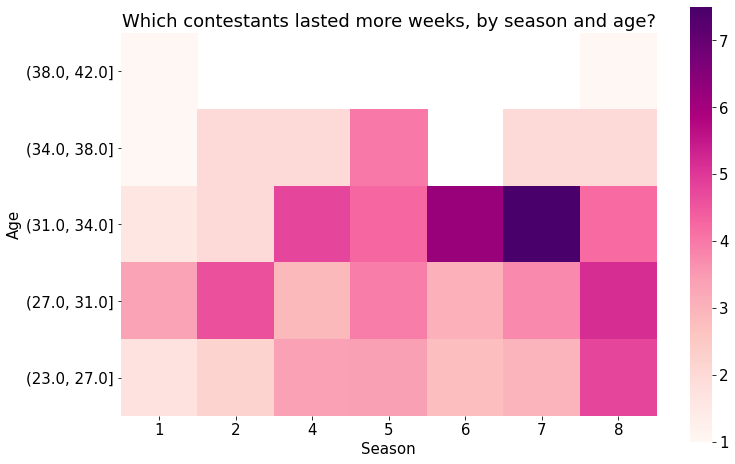

In [20]:
make_heatmap(train)

Beginning with the first season of The Bachelorette (which aired in 2003), it looks like the overall trend across seasons and time was increasingly favorsome towards younger contestants... That is, until Season 12 decided to invert that trend.

### Does getting one of the first dates in the season mean that a contestant will get more One-on-One time?

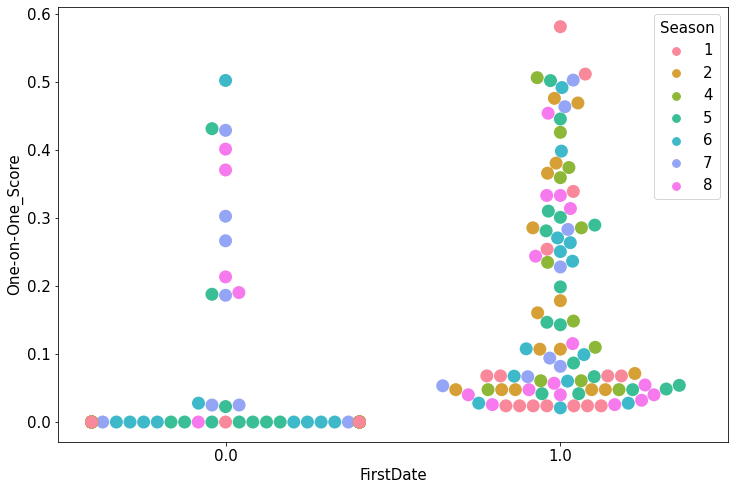

In [21]:
firstdate_swarmplot(train)

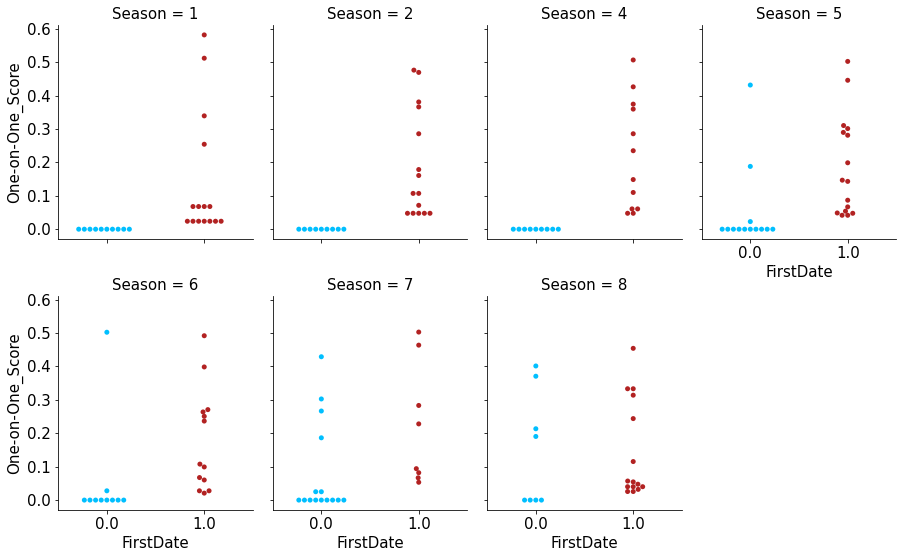

In [22]:
swarmplot_by_season(train)

For the most part, contestants that didn't get one of the first dates with the bachelorette didn't get nearly as much future date time as their counterparts who *did* go on one of the first dates.

In two seasons, however, the contestants who ended up getting the highest One-on-One scores actually did *not* get one of the first dates of their respective seasons.

Getting one of the First Dates does have a great effect on a contestant's future time with the bachelorette, but it's not necessarily a game-ender.

In fact, most of the contestants that went on to get any date time at all with the bachelorette -- after not going on a 'FirstDate' -- actually got more time than many of the other contestants who did go on a 'FirstDate'.

### Is there a linear relationship between One-on-One_Score and ElimWeek?

$
\begin{align*}
   H_0 & : \text{There is no linear correlation between a contestant's One-on-One Score and a contestant's Elimination Week.}
   \\
   H_a & : \text{There is a linear correlation between a contestant's One-on-One Score and a contestant's Elimination Week.}
   \\
    \alpha & : \text{0.05}
\end{align*}
$

In [23]:
alpha = 0.05
x = train['One-on-One_Score']
y = train.ElimWeek

In [24]:
pearsons_test(train, x, y, alpha)

r = 0.8377015803155536
p = 1.8111770699724813e-45


We reject the hypothesis that there is no linear correlation between a contestant's One-on-One Score and a contestant's Elimination Week.


## Predictive Modeling

# Can our model predict how long contestants will last on the show (in weeks), using data only from the first three episodes of a season?

**The goal is to produce a predictive model that outperforms the baseline in predicting the target value -- in this case, ```ElimWeek```.**

### Define and Evaluate Baseline

In [25]:
#np.median(y_train)
np.mean(y_train)

3.5357142857142856

In [26]:
#baseline = y_train.median()
baseline = y_train.mean()

evaluate_baseline(baseline, y_train, y_validate)

RMSE (Root Mean Square Error) of Baseline on train data:
 3.862457
RMSE (Root Mean Square Error) of Baseline on validate data:
 4.745429


Mean performed better than median. So, my baseline will be ```3.5357142857142856``` with a RMSE of ```3.862457``` on train.

### Model 1 - Ordinary Least Squares (OLS) using Linear Regression

In [27]:
# show features
X_train.columns

Index(['Age', 'Season', 'One-on-One_Score', 'FirstDate', 'Homestate',
       'HomestateAbbr', 'HomeRegion'],
      dtype='object')

In [28]:
# use all features except season

X = X_train.drop(columns=['Season'])
y = y_train

X_v = X_validate.drop(columns=['Season'])
y_v = y_validate

lm_pred, lm_rmse, lm_pred_v, lm_rmse_v = model_1(X, y, X_v, y_v)

ValueError: could not convert string to float: 'Colorado'

This model performs better than the baseline on both train and validate. 🎉

**Now that I know Model 1 is the best performing, I will test it on the test data.**

In [ ]:
# use all features except season

X = X_test.drop(columns=['Season'])
y = y_test

lm_pred, lm_rmse = model_1_test(X, y)

**Looks good!! Model 1 performs the best and beats the baseline.** 🥳

## Conclusions

New train, validate, test splits:
```
Seasons 1 to 8 (66.67%) | Seasons 9 and 10 (16.667%) | Seasons 11 and 12 (16.667%)
```

In the future I'd like to analyze this as a time series, sampled by week and divided by season.

### Note to self: A better, more honest metric...
**One-on-One score per episode, divided (or multiplied? idk im tired) by the number of people left on the show that week (in addition to the rest of my calculations)**

Go to sleep now. Stop coding... 😴😴😴😴😴😴😴😴